### Import Packages

In [90]:
# python version 3.10.11
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import pickle as pkl
import pandas as pd

from scipy.stats import norm
%config InlineBackend.figure_format = 'retina'
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally



from ax.core.observation import ObservationFeatures
from ax.core.objective import ScalarizedObjective
from ax.core.optimization_config import OptimizationConfig
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge.factory import get_GPEI
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep


from ax import *
from ax.core import ParameterType, RangeParameter, SearchSpace, OptimizationConfig#, ScalarizedObjective

import pandas as pd
import torch
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge import get_sobol
from ax.modelbridge.factory import get_GPEI
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.service.ax_client import AxClient
from botorch.acquisition import qNegIntegratedPosteriorVariance, qNoisyExpectedImprovement, qUpperConfidenceBound
from botorch.models import SingleTaskGP
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement, 
)
from botorch.models.gp_regression import FixedNoiseGP


# from botorch.acquisition import qUpperConfidenceBound
from botorch.acquisition.monte_carlo import qUpperConfidenceBound

from botorch.acquisition.input_constructors import acqf_input_constructor




### Load Functions

In [2]:
def generate_mesh(I_range, Br_range, Cl_range):
    """
    Generate a mesh of points for I, Br, and Cl that sum to 1.

    :param I_range: Tuple of (start, end, step) for I.
    :param Br_range: Tuple of (start, end, step) for Br.
    :param Cl_range: Tuple of (start, end, step) for Cl.
    :return: List of [I, Br, Cl] points that sum to 1.
    """
    mesh = []
    I_start, I_end, I_step = I_range
    Br_start, Br_end, Br_step = Br_range
    Cl_start, Cl_end, Cl_step = Cl_range

    I_values = np.linspace(I_start, I_end, round((I_end - I_start) / I_step) + 1)
    Br_values = np.linspace(Br_start, Br_end, round((Br_end - Br_start) / Br_step) + 1)
    Cl_values = np.linspace(Cl_start, Cl_end, round((Cl_end - Cl_start) / Cl_step) + 1)

    for i in I_values:
        for br in Br_values:
            for cl in Cl_values:
                if abs(br + cl + i - 1) < 1e-4:  # Add a small tolerance to deal with floating point precision
                    mesh.append([i, br, cl])

    return mesh



def make_targets(MA_values, mesh_array):
    # Create solutions
    targets = []
    for MA in MA_values:
        for i, br, cl in mesh_array:
            targets.append(make_solution(MA, i, cl))
    return targets


def plot_mesh(bx_excess_values, color='red', fig=None, **marker_kwargs):
    if fig is None:
        fig = go.Figure()
    fig.add_trace(go.Scatter(x=bx_excess_values, mode='markers', marker=dict(color=color, **marker_kwargs)))
    fig.update_layout({'plot_bgcolor': 'white', 'paper_bgcolor': 'white'})
    return fig

def plot_BO_mesh(bx_excess_values, acq_values, fig=None, **marker_kwargs):
    if fig is None:
        fig = go.Figure()
    fig.add_trace(go.Scatter(x=bx_excess_values, y=acq_values, mode='markers', marker=dict(colorscale='Viridis', **marker_kwargs)))
    fig.update_layout({'plot_bgcolor': 'white', 'paper_bgcolor': 'white'})
    return fig



def enforce_minimum_distance(ax_client, num_trials, min_distance):
    new_points = []
    trial_indices = []
    while len(new_points) < num_trials:
        # Get a batch of points from the optimizer
        batch_trial_indices, _ = ax_client.get_next_trials(1)
        if not batch_trial_indices:  # If no new trials were generated, break the loop
            break
        for trial_index in batch_trial_indices:
            trial = ax_client.get_trial(trial_index)
            point = trial.arm.parameters
            point_vector = np.array(list(point.values()))  # Convert the point to a vector
            # Check if the point is far enough from all existing points
            if all(np.linalg.norm(point_vector - np.array(list(existing_point.values()))) >= min_distance for existing_point in new_points):
                new_points.append(point)
                trial_indices.append(trial_index)
    return trial_indices


def create_experiment(ax_client, search_parameters, objectives, parameter_constraints):
    ax_client.create_experiment(
        name="moo_experiment",
        parameters=search_parameters,
        objectives=objectives,
        parameter_constraints=parameter_constraints,
        overwrite_existing_experiment=True,
    )

def complete_trials(ax_client, df, standard_errors):
    for _, row in df.iterrows():
        metrics_data = {}
        for metric, standard_error in standard_errors.items():
            if pd.notnull(row[metric]):
                metrics_data[metric] = (row[metric], standard_error)
        if metrics_data:
            trial_parameters = {'bx_excess': row['bx_excess']}
            _, trial_index = ax_client.attach_trial(trial_parameters)
            ax_client.complete_trial(trial_index=trial_index, raw_data=metrics_data)

def create_suggested_samples_df(ax_client, batch_trial_indices):
    suggested_samples = []
    for trial_index in batch_trial_indices:
        trial = ax_client.get_trial(trial_index)
        arm_parameters = trial.arm.parameters
        suggested_samples.append(arm_parameters)
    df_suggested = pd.DataFrame(suggested_samples)
    df_suggested['bx_excess'] = df_suggested['bx_excess'].round(8)
    return df_suggested

# def evaluate_acquisition_function(ax_client, search_parameters, metrics, weights):
    
    
def evaluate_acquisition_function(ax_client, search_parameters, metrics, weights):
    model = ax_client.generation_strategy.model  # Get the current model
    
    # Check if the model is None (likely during Sobol steps)
    if model is None:
        print("Model is None. Likely in Sobol initialization step.")
        return None  # or some other default value
    
    model_name = model.__class__.__name__  # Get the name of the model class
    
    # Check if the model is a Sobol model
    if model_name == 'RandomModelBridge':  
        print("In Sobol initialization step. Skipping prediction.")
        return np.zeros(101)  # or some other default value
    
    # If it's GPEI or another model-based strategy
    if model_name == 'GPEI':
    
    

        model = ax_client.generation_strategy.model
        x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], 101)
        acq_values = np.zeros(len(x_eval))
        metric_names = [metric.name for metric in metrics]
        for i, x in enumerate(x_eval):
            plot_parameters = [ObservationFeatures(parameters={'bx_excess': x})]
            acq_values_dict, _ = model.predict(plot_parameters)
            scalarized_acq_value = 0
            for metric_name, weight in zip(metric_names, weights):
                acq_value = acq_values_dict[metric_name][0]
                scalarized_acq_value += weight * acq_value
            acq_values[i] = scalarized_acq_value
        return acq_values





def get_batch_trial_indices(ax_client, num_trials, min_distance=None):
    if min_distance is not None:
        return enforce_minimum_distance(ax_client, num_trials=num_trials, min_distance=min_distance)
    else:
        trial_indices, _ = ax_client.get_next_trials(num_trials)
        return trial_indices
    
    
def create_mesh_array(search_parameters, num_points=101):
    """
    Create a mesh array from the evaluation points.
    
    Args:
        search_parameters (list[dict]): The search parameters.
        num_points (int, optional): The number of points to evaluate. Defaults to 101.
    
    Returns:
        np.ndarray: The mesh array.
    """
    # Define points at which we'll evaluate the acquisition function
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], num_points)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], num_points)

    # Create a mesh array from the evaluation points
    mesh_array = np.zeros((len(x_eval), len(y_eval), 3))
    mesh_array[:, :, 0] = x_eval[:, None]
    mesh_array[:, :, 1] = y_eval[None, :]
    mesh_array[:, :, 2] = 1 - x_eval[:, None] - y_eval[None, :]

    return mesh_array


def flatten_mesh_array(mesh_array):
    return mesh_array.reshape(-1, 3), acq_values.flatten()

def plot_acquisition_function(bx_excess_values, acq_values):
    fig = plot_BO_mesh(bx_excess_values, acq_values)
    return fig

def plot_data_points(df, df_suggested, fig):
    bx_excess_values_0 = df['bx_excess'].values
    bx_excess_values_1 = df_suggested['bx_excess'].values
    fig = plot_mesh(bx_excess_values_0, color='black', fig=fig)
    fig = plot_mesh(bx_excess_values_1, color='red', fig=fig)
    return fig



def complete_trials_and_get_new_df(ax_client, batch_trial_indices, df):
    new_rows = []
    for trial_index in batch_trial_indices:
        trial = ax_client.get_trial(trial_index)
        parameters = trial.arm.parameters
        metric_value = np.random.uniform(low=0.1, high=.5, size=(1,))[0]  # TODO: replace with actual function
        ax_client.complete_trial(trial_index=trial_index, raw_data={'pce_negative': (metric_value, 0.0)})
        parameters['pce_negative'] = metric_value  # store the metric value in the parameters
        new_rows.append(parameters)

    # Append the new rows to the original DataFrame
    df_new = pd.DataFrame(new_rows)
    df_new = pd.concat([df, df_new], ignore_index=True)

    return df_new

import matplotlib.gridspec as gridspec
class MinorTicker(ticker.MultipleLocator):
    def __init__(self, n_ticks, *args, **kwargs):
        self.n_ticks = n_ticks
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        vmin, vmax = self.axis.get_view_interval()
        major_ticks = self.axis.get_majorticklocs()
        minor_intervals = [(major_ticks[i+1] - major_ticks[i]) / (self.n_ticks + 1) for i in range(len(major_ticks)-1)]
        minor_ticks = []
        for interval, major_tick in zip(minor_intervals, major_ticks[:-1]):
            minor_ticks.extend([major_tick + interval * (i + 1) for i in range(self.n_ticks)])
        return minor_ticks
    
def evaluate_acquisition_function_for_plot(ax_client, bx_excess_values, metrics, weights):
    model = ax_client.generation_strategy.model
    acq_values = np.zeros(len(bx_excess_values))
    variances = np.zeros(len(bx_excess_values))
    metric_names = [metric.name for metric in metrics]
    for i, x in enumerate(bx_excess_values):
        plot_parameters = [ObservationFeatures(parameters={'bx_excess': x})]
        acq_values_dict, cov_matrix = model.predict(plot_parameters)
        scalarized_acq_value = 0
        for metric_name, weight in zip(metric_names, weights):
            acq_value = acq_values_dict[metric_name][0]
            scalarized_acq_value += weight * acq_value
        acq_values[i] = scalarized_acq_value
        variances[i] = cov_matrix['pce_negative']['pce_negative'][0]
    return bx_excess_values, acq_values, variances


def calculate_expected_improvement(mu, sigma, f_best, xi=0.9):
    with np.errstate(divide='ignore'):
        Z = (f_best - mu - xi) / sigma
        ei = (f_best - mu - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma == 0.0] = 0.0  # handle sigma = 0
    return ei


def plot_data_points(df, df_suggested, ax):  # Updated the argument name here from fig to ax
    # ax = fig  # You don't need this line anymore
    bx_excess_values_1 = df_suggested['bx_excess'].values
    # Define a constant value lower than the minimum acquisition value for the y-coordinate of the red lines
    ymin = np.min(ax.get_ylim())  # Updated this line to remove the gca() call
    red_line_y_values = np.full_like(bx_excess_values_1, ymin)  # This creates an array filled with the constant value
    ax.plot(bx_excess_values_1, red_line_y_values, 'r|', markersize=10, label='BO Suggestion')  # Plot suggested points as red lines
    ax.legend()
    return ax  # Updated to return the ax object


def plot_combined(ax_client, bx_excess_values, acq_values):
    fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True, 
                            gridspec_kw={'height_ratios': [4, 1]})
    
    model = ax_client.generation_strategy.model
    x_new = np.linspace(min(bx_excess_values), max(bx_excess_values), 300)
    predicted_means = []
    variances = []
    for x in x_new:
        plot_parameters = [ObservationFeatures(parameters={'bx_excess': x})]
        predicted_value_dict, cov_matrix = model.predict(plot_parameters)
        predicted_means.append(predicted_value_dict['pce_negative'][0])
        variances.append(cov_matrix['pce_negative']['pce_negative'][0])
    
    variances = np.array(variances)
    ax = axs[0]
    ax.plot(x_new, predicted_means, 'b-', label='Predicted Mean')
    ax.scatter(bx_excess_values, acq_values, c='purple', label='Acquisition Value')
    upper_bound = np.array(predicted_means) + 1.96 * np.sqrt(variances)
    lower_bound = np.array(predicted_means) - 1.96 * np.sqrt(variances)
    ax.fill_between(x_new, lower_bound, upper_bound, color='blue', alpha=0.1, label='95% Confidence Interval')
    ax.axhline(y=min(acq_values), color='r', linestyle='--')
    ax.set_ylabel(f'$f(x)$ (a.u.)')
    ax.yaxis.set_ticks([])
    ax.legend()
    ax.grid(True)
    
    ax = axs[1]
    f_best = min(acq_values)
    ei_values = calculate_expected_improvement(np.array(predicted_means), np.sqrt(variances), f_best)
    ax.plot(x_new, ei_values, 'b-')
    ax.set_xlabel('bx_excess')
    ax.set_ylabel(f'$EI(x)$ (a.u.)')
    n_minor_ticks_between_major = 4
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n_minor_ticks_between_major))
    # ax.legend()
    ax.grid(True)
    ax.yaxis.set_ticks([])
    plot_data_points(None, df_suggested, ax)  # Updated this line to pass the ax object

    
    plt.tight_layout()
    return fig

def get_qNEI(gp):
    return qNoisyExpectedImprovement(gp)




### Import Data

In [3]:
rawdf = pd.read_pickle('JV_demo_data.pkl')

df = rawdf

df['bx_excess'] = pd.to_numeric(df['bx_excess'], errors='coerce').fillna(0)
df['pce_negative'] = -abs(df['pce'])
df = df.dropna(subset=['pce'])


## Run BO With Enseble Method (user defined fractional mixture of models)

In [100]:
# Initialize the AxClient
ax_client = AxClient()

# Total number of trials
num_trials = 10
# xi parameter (0 for full exploitation, 1 for full exploration)
xi = .2

# Calculate the number of trials for exploration and exploitation
num_explore = round(num_trials * xi)
num_exploit = num_trials - num_explore

# Ensure that num_exploit is at least 1
if num_exploit < 1:
    num_exploit = 1
    num_explore = num_trials - 1  # Adjust num_explore accordingly

# Define your metrics
metrics = [L2NormMetric('pce_negative', param_names=['bx_excess'])]

# Create a ScalarizedObjective
weights = [1]
objective = ScalarizedObjective(metrics=metrics, weights=weights)

# Create an ScalarizedOptimizationConfig
optimization_config = OptimizationConfig(objective=objective)

# Define a dictionary that maps each metric to its corresponding standard error
standard_errors = {
    'pce_negative': 0.1,
}

# Define your search space and optimization parameters
search_parameters = [
    {"name": "bx_excess", "type": "range", "bounds": [0.0, 1.0], "value_type": "float"},
    # ... add more parameters or expand bounds if necessary ...
]



gs_SOBOL = GenerationStrategy(
    # name="Sobol",
    steps=[
        GenerationStep(
            # model=Models.SOBOL, 
            model=get_sobol, 
            num_trials=num_trials, 
            # model_kwargs={
            #     "deduplicate": True,  # Deduplicate trials
            # }
        ),
    ],
)



gs_qNEHI = GenerationStrategy(
    steps=[
        # GenerationStep(model=get_sobol, num_trials=num_explore),
        GenerationStep(model=get_GPEI, num_trials=num_exploit,
                       model_kwargs={
                           "acquisition_function_kwargs": {
                               "acquisition_function_constructor": qNoisyExpectedHypervolumeImprovement,
                               "ref_point": [0.0],  # Reference point
                               "X_baseline": None  # You can set this if needed
                           }
                       })
    ]
)

d = 1  # dimension of your parameter space
num_mc_points = 100  # number of MC points
mcp_0 = torch.rand(num_mc_points, d)

# mcp_1 = torch.tensor(mc_points)

gs_qNIPV = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=num_explore,
            model_kwargs={
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options" : {"mc_points" : mcp_0}}
            
        ),
    ]
)


gs_qNEI = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=num_exploit,
            model_kwargs={
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNoisyExpectedImprovement,
            },
        ),
    ]
)



combined = True
if combined:
    # Re-initialize the AxClient with the updated generation strategy
    ax_client = AxClient(generation_strategy=gs_qNIPV, verbose_logging=True)

    # Create the experiment
    ax_client.create_experiment(
        name="my_experiment",
        parameters=search_parameters,
        objective_name='pce_negative',
        minimize=True,
        parameter_constraints=None,
        overwrite_existing_experiment=True
    )

    # Complete trials
    complete_trials(ax_client, df, standard_errors)

    # Get batch_trial_indices
    enforce_min_distance = False  # Set this to True if you want to enforce minimum distance
    min_distance = 0.05 if enforce_min_distance else None
    batch_trial_indices = get_batch_trial_indices(ax_client, num_trials=num_explore, min_distance=min_distance)

    # Create a DataFrame of the suggested samples
    df_suggested_explore = create_suggested_samples_df(ax_client, batch_trial_indices)

    # Evaluate the acquisition function
    acq_values = evaluate_acquisition_function(ax_client, search_parameters, metrics, weights)

# Re-initialize the AxClient with the updated generation strategy
ax_client = AxClient(generation_strategy=gs_qNEI, verbose_logging=True)

# Create the experiment
ax_client.create_experiment(
    name="my_experiment",
    parameters=search_parameters,
    objective_name='pce_negative',
    minimize=True,
    parameter_constraints=None,
    overwrite_existing_experiment=True
)

# Complete trials
complete_trials(ax_client, df, standard_errors)

# Get batch_trial_indices
enforce_min_distance = False  # Set this to True if you want to enforce minimum distance
min_distance = 0.05 if enforce_min_distance else None
batch_trial_indices = get_batch_trial_indices(ax_client, num_trials=num_exploit, min_distance=min_distance)

# Create a DataFrame of the suggested samples
df_suggested_exploit = create_suggested_samples_df(ax_client, batch_trial_indices)

# Evaluate the acquisition function
acq_values = evaluate_acquisition_function(ax_client, search_parameters, metrics, weights)

if combined:
    df_suggested = pd.concat([df_suggested_explore, df_suggested_exploit], ignore_index=True)
else:
    df_suggested = df_suggested_exploit

print(df_suggested)

[INFO 10-24 23:19:14] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
/Users/deniz/anaconda3/envs/ds310b/lib/python3.10/site-packages/ax/modelbridge/model_spec.py:313: UserWarning: Using a factory function to describe the model, so optimization state cannot be stored and optimization is not resumable if interrupted.
  warnings.warn(
[INFO 10-24 23:19:14] ax.modelbridge.generation_strategy: Using model via callable function, so optimization is not resumable if interrupted.
[INFO 10-24 23:19:14] ax.modelbridge.generation_strategy: Using model via callable function, so optimization is not resumable if interrupted.
[INFO 10-24 23:19:14] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO

   bx_excess
0   0.740819
1   0.740491
2   0.805513
3   0.929936
4   0.700381
5   0.841244
6   0.857180
7   0.969441
8   0.665068
9   0.726583


### Plot the result

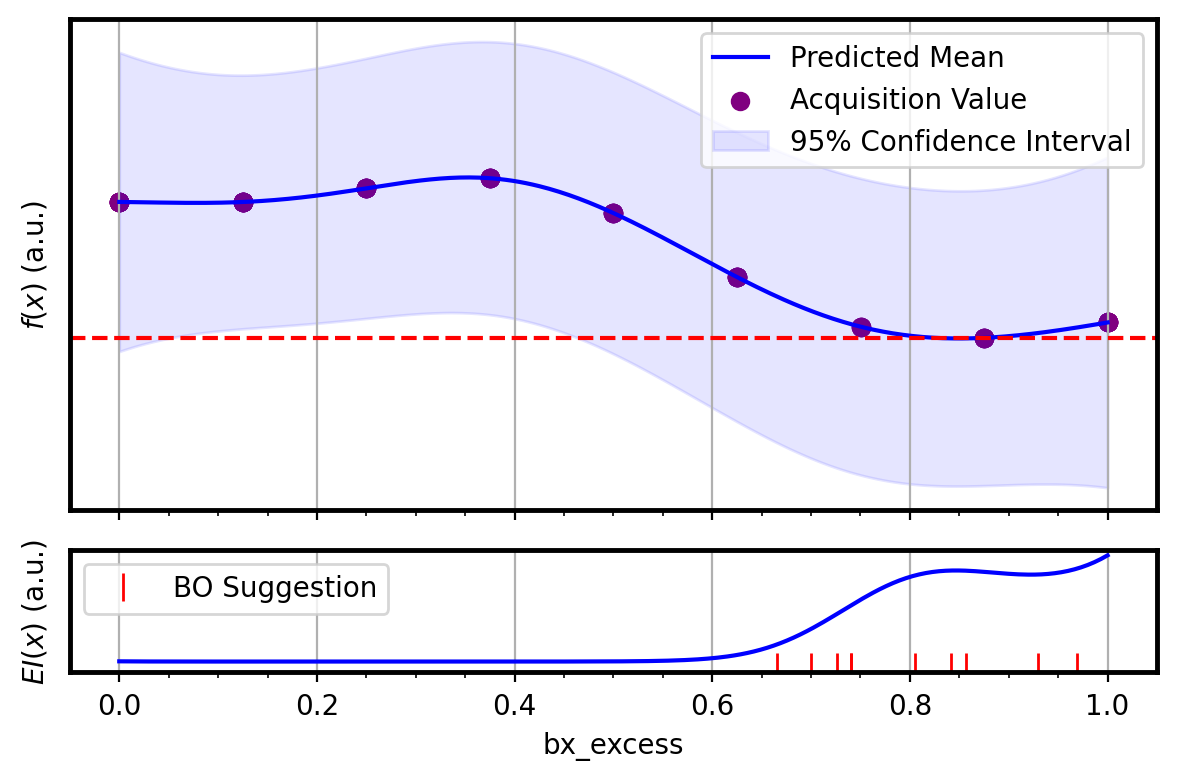

In [101]:
# Call the modified evaluate_acquisition_function
bx_excess_values, acq_values, variances = evaluate_acquisition_function_for_plot(ax_client, df['bx_excess'].values, metrics, weights)

# Call the modified plot_combined function
fig = plot_combined(ax_client, bx_excess_values, acq_values)
plt.show()

## Run BO with Upper Confidence Bound (user defined beta value)

In [95]:
# Initialize the AxClient
ax_client = AxClient()

# Total number of trials
num_trials = 10
# xi parameter (0 for full exploitation, 1 for full exploration)
xi = .2

# Calculate the number of trials for exploration and exploitation
num_explore = round(num_trials * xi)
num_exploit = num_trials - num_explore

# Ensure that num_exploit is at least 1
if num_exploit < 1:
    num_exploit = 1
    num_explore = num_trials - 1  # Adjust num_explore accordingly

# Define your metrics
metrics = [L2NormMetric('pce_negative', param_names=['bx_excess'])]

# Create a ScalarizedObjective
weights = [1]
objective = ScalarizedObjective(metrics=metrics, weights=weights)

# Create an ScalarizedOptimizationConfig
optimization_config = OptimizationConfig(objective=objective)

# Define a dictionary that maps each metric to its corresponding standard error
standard_errors = {
    'pce_negative': 0.1,
}

# Define your search space and optimization parameters
search_parameters = [
    {"name": "bx_excess", "type": "range", "bounds": [0.0, 1.0], "value_type": "float"},
    # ... add more parameters or expand bounds if necessary ...
]



gs_SOBOL = GenerationStrategy(
    # name="Sobol",
    steps=[
        GenerationStep(
            # model=Models.SOBOL, 
            model=get_sobol, 
            num_trials=num_trials, 
            # model_kwargs={
            #     "deduplicate": True,  # Deduplicate trials
            # }
        ),
    ],
)



gs_qNEHI = GenerationStrategy(
    steps=[
        # GenerationStep(model=get_sobol, num_trials=num_explore),
        GenerationStep(model=get_GPEI, num_trials=num_exploit,
                       model_kwargs={
                           "acquisition_function_kwargs": {
                               "acquisition_function_constructor": qNoisyExpectedHypervolumeImprovement,
                               "ref_point": [0.0],  # Reference point
                               "X_baseline": None  # You can set this if needed
                           }
                       })
    ]
)

d = 1  # dimension of your parameter space
num_mc_points = 100  # number of MC points
mcp_0 = torch.rand(num_mc_points, d)

# mcp_1 = torch.tensor(mc_points)

gs_qNIPV = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=num_explore,
            model_kwargs={
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options" : {"mc_points" : mcp_0}}
            
        ),
    ]
)


gs_qNEI = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=num_exploit,
            model_kwargs={
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNoisyExpectedImprovement,
            },
        ),
    ]
)



beta = 1 #1 -> more exploration, 0 -> more exploitation, controls the trade off between mean and standard deviation 
qUCB = qUpperConfidenceBound(Surrogate(SingleTaskGP), beta=beta, objective=objective)
gs_qUCB = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,
            model_kwargs={ 
            "surrogate": Surrogate(SingleTaskGP),
            "botorch_acqf_class": qUpperConfidenceBound,  
            "acquisition_options": {"beta" : beta}})])

 
# Re-initialize the AxClient with the updated generation strategy
ax_client = AxClient(generation_strategy=gs_qUCB, verbose_logging=True)

# Create the experiment
ax_client.create_experiment(
    name="my_experiment",
    parameters=search_parameters,
    objective_name='pce_negative',
    minimize=True,
    parameter_constraints=None,
    overwrite_existing_experiment=True
)

# Complete trials
complete_trials(ax_client, df, standard_errors)

# Get batch_trial_indices

enforce_min_distance = False  # Set this to True if you want to enforce minimum distance
min_distance = 0.05 if enforce_min_distance else None
batch_trial_indices = get_batch_trial_indices(ax_client, num_trials=10, min_distance=min_distance)

# Create a DataFrame of the suggested samples
df_suggested = create_suggested_samples_df(ax_client, batch_trial_indices)

# Evaluate the acquisition function
acq_values = evaluate_acquisition_function(ax_client, search_parameters, metrics, weights)

print(df_suggested)


[INFO 10-24 23:16:58] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
/Users/deniz/anaconda3/envs/ds310b/lib/python3.10/site-packages/ax/modelbridge/model_spec.py:313: UserWarning: Using a factory function to describe the model, so optimization state cannot be stored and optimization is not resumable if interrupted.
  warnings.warn(
[INFO 10-24 23:16:58] ax.modelbridge.generation_strategy: Using model via callable function, so optimization is not resumable if interrupted.
[INFO 10-24 23:16:58] ax.modelbridge.generation_strategy: Using model via callable function, so optimization is not resumable if interrupted.
[INFO 10-24 23:16:58] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO

[INFO 10-24 23:16:58] ax.core.experiment: Attached custom parameterizations [{'bx_excess': 0.0}] as trial 0.
[INFO 10-24 23:16:58] ax.service.ax_client: Completed trial 0 with data: {'pce_negative': (-20.42, 0.1)}.
[INFO 10-24 23:16:58] ax.core.experiment: Attached custom parameterizations [{'bx_excess': 1.0}] as trial 1.
[INFO 10-24 23:16:58] ax.service.ax_client: Completed trial 1 with data: {'pce_negative': (-20.3, 0.1)}.
[INFO 10-24 23:16:58] ax.core.experiment: Attached custom parameterizations [{'bx_excess': 0.875}] as trial 2.
[INFO 10-24 23:16:58] ax.service.ax_client: Completed trial 2 with data: {'pce_negative': (-19.88, 0.1)}.
[INFO 10-24 23:16:58] ax.core.experiment: Attached custom parameterizations [{'bx_excess': 0.625}] as trial 3.
[INFO 10-24 23:16:58] ax.service.ax_client: Completed trial 3 with data: {'pce_negative': (-19.57, 0.1)}.
[INFO 10-24 23:16:58] ax.core.experiment: Attached custom parameterizations [{'bx_excess': 0.5}] as trial 4.
[INFO 10-24 23:16:58] ax.ser

   bx_excess
0   0.848660
1   1.000000
2   0.737283
3   0.660309
4   0.918319
5   0.575946
6   0.794854
7   0.644499
8   0.000000
9   0.456405


### Plot Result

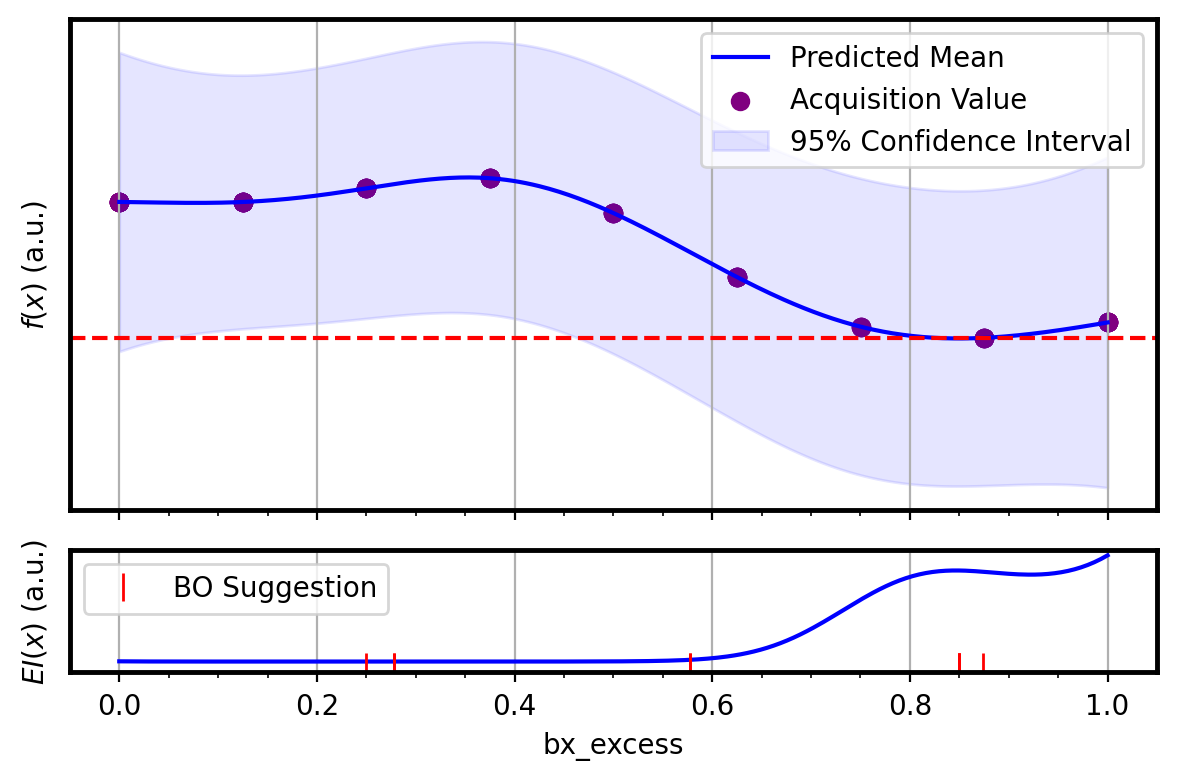

At Beta: 0 Std: 0.2551243753674255


In [92]:
# Call the modified evaluate_acquisition_function
bx_excess_values, acq_values, variances = evaluate_acquisition_function_for_plot(ax_client, df['bx_excess'].values, metrics, weights)

# Call the modified plot_combined function
fig = plot_combined(ax_client, bx_excess_values, acq_values)
plt.show()
print('At Beta:',beta, 'Std:', np.std(df_suggested['bx_excess'].values) )

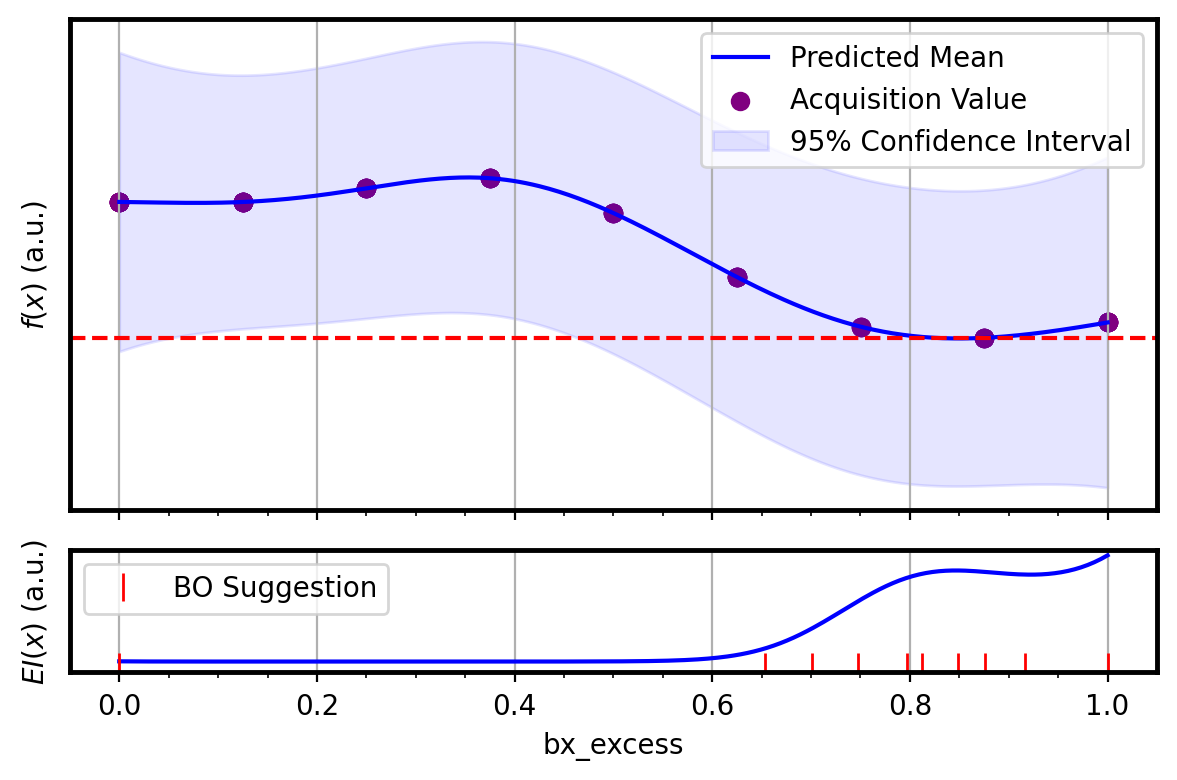

At Beta: 0.5 Std: 0.26344770245992694


In [94]:
# Call the modified evaluate_acquisition_function
bx_excess_values, acq_values, variances = evaluate_acquisition_function_for_plot(ax_client, df['bx_excess'].values, metrics, weights)

# Call the modified plot_combined function
fig = plot_combined(ax_client, bx_excess_values, acq_values)
plt.show()
print('At Beta:',beta, 'Std:', np.std(df_suggested['bx_excess'].values) )

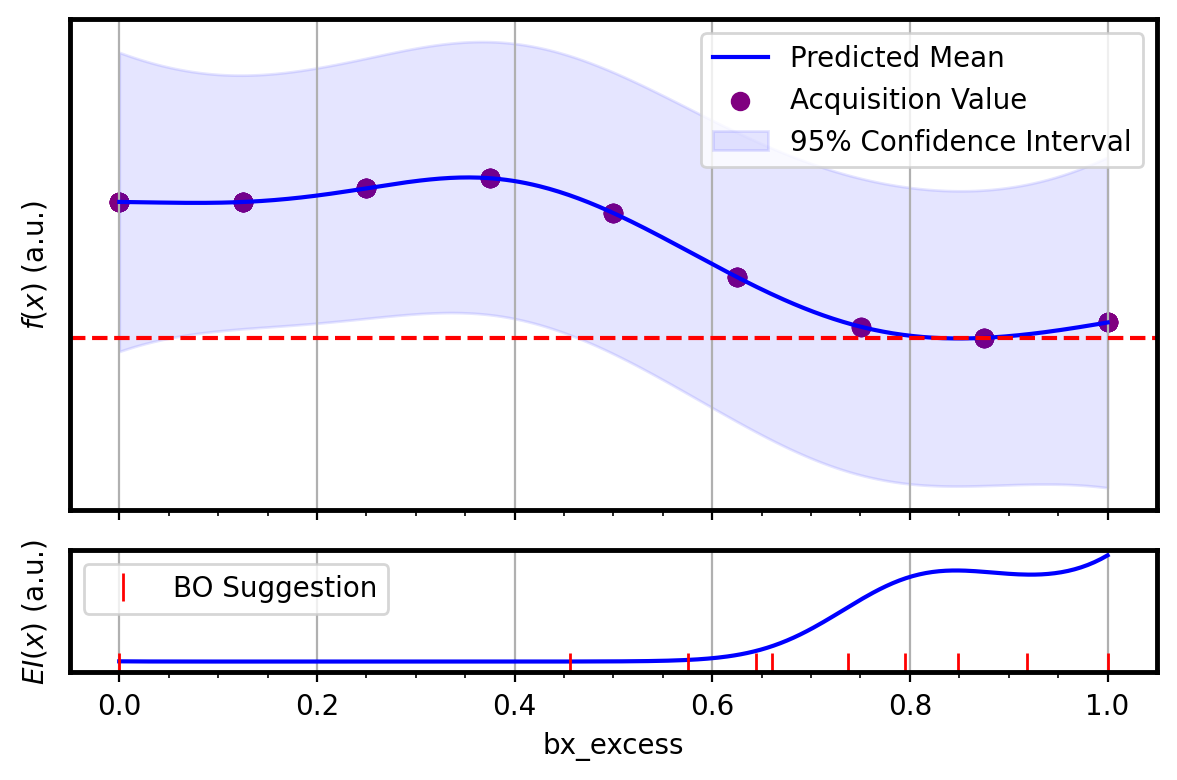

At Beta: 1 Std: 0.26950031984944445


In [96]:
# Call the modified evaluate_acquisition_function
bx_excess_values, acq_values, variances = evaluate_acquisition_function_for_plot(ax_client, df['bx_excess'].values, metrics, weights)

# Call the modified plot_combined function
fig = plot_combined(ax_client, bx_excess_values, acq_values)
plt.show()
print('At Beta:',beta, 'Std:', np.std(df_suggested['bx_excess'].values) )